In [17]:
import csv
import os
import re
import pandas as pd
import argparse
from utils.csv_utils import sort_csv_by_column

# Index positions for each element in a row
# level= 0
# pagenum = 1
# block_num = 2
# par_num = 3
# line_num = 4
# word_num = 5
# left = 6
# top = 7
# width = 8
# height = 9
# conf = 10
# text = 11

def load_csv_filenames(csv_dir):
    """Takes a path to a directory with CSVs, then adds all of the paths of
    the CSV files in that directory to the filenames list, which is returned.
    
    Parameters:
        csv_dir - String containing file system location of CSV files.
    Returns:
        filenames - Updated list of CSV file paths.
    """
    filenames = []
    # Scan recursively over all tsv files in a directory
    for folder, subfolders, files in os.walk(csv_dir):
        for file in files:
            if file.endswith('.csv'):
                #Add all the .pdf filenames to a list
                filename = os.path.join(folder, file)
                filenames.append(filename)
                
    return filenames

def left_is_close(list1, list2, dist):
    # Make the list elements numerical so numerical comparisons will be easier
    list1 = list(map(transform_element, list1))
    list2 = list(map(transform_element, list2))
    
    # First determine the leftmost text out of the two, then use that to 
    # check if the words should be joined together.
    if list1[6] < list2[6]:
        return (abs((list1[6] + list1[8]) - list2[6]) <= dist)
    else: 
        return (abs((list2[6] + list2[8]) - list1[6]) <= dist)
    
def top_is_close(line1, line2, dist):
    # Determine if the top coordinates of the two lines are within dist of
    # each other
    return (abs((int(line1[7]) + int(line1[9])) - 
                (int(line2[7]) + int(line2[9]))) <= dist)

def transform_element(item):
    # Attempts to change the item's to a float. If that doesn't work then the
    # item is returned as is. If it does work, then it will then either return
    # the float or change the float to an int and return that if possible.
    try:
        num = float(item)
    except (TypeError, ValueError):
        return item
    else:
        if num.is_integer():
            return int(num)
        else:
            return num


def combine_lines(list1, list2):
    # Calculate the new coordinate information for combined text
    left = min(list1[6], list2[6])
    top = min(list1[7], list2[7])
    height = max(list1[9], list2[9])
    conf = ((list1[10] / 100) * (list2[10]/ 100)) * 100
    
    # Ensure that the lists can be passed to this function in any order
    if left == list1[6]:
        width = abs((list2[6] + list2[8]) - list1[6])
        text = f'{list1[11]} {list2[11]}'
    else:
        width = abs((list1[6] + list1[8]) - list2[6])
        text = f'{list2[11]} {list1[11]}'

    # Change the elements of the new list to all strings again, and return
    combined_list = list1[:6].copy()
    combined_list.extend([left, top, width, height, conf, text])

    return combined_list
    
def clean_dataframe(df):
    # Remove all text entries that are set as 'Nan'
    tmp_df = df.dropna(subset=['text'])
    # Filter out the rows of every text entry that contains spaces and/or '|'
    filtered = tmp_df[tmp_df.text.str.fullmatch('\ *\|?')].index
    # Drop the rows that were just filtered out
    filtered_df = tmp_df.drop(filtered)
    mask = (filtered_df.width * filtered_df.height) < 100
    new_df = filtered_df[~mask]
    return new_df

def realign_text(orig_df, left_dist_def, top_dist_def):
    # Clean the dataframe
    df = clean_dataframe(orig_df)
    # Convert the dataframe to a list
    ref_list = df.values.tolist()
    realigned = ref_list.copy()
    # Keep track of whether or not any changes were made in the latest 
    # iteration. Initialize to True so the while-loop will start.
    modified = True
    # Continue realigning the text until no changes are made
    while modified:
        # Reset to false for beginning of loop
        modified = False
        # Compare every row to every other row only once. Do not compare a row 
        # to itself
        for index, item1 in enumerate(ref_list):
            for item2 in ref_list[index+1:]:
                # Searching for special entires
                if re.search('well.class:?', item1[11]):
                    left_dist = left_dist_def + 60
                elif re.search('well.?(#|no)?:?\ ?.*', item1[11], re.IGNORECASE):
                    if not re.search('(wells.*|.*ask\ us.*|well.class.*|elev\ ?chgd.*|rocky.mount)', item1[11], re.IGNORECASE):
                        left_dist = left_dist_def + 80
                elif re.search('(OPR|OPERATOR):?\ ?.*', item1[11], re.IGNORECASE):
                    left_dist = left_dist_def + 100
                elif re.search('CSG:?\ ?', item1[11], re.IGNORECASE):
                    left_dist = left_dist_def + 70
                else:
                    left_dist = left_dist_def

                top_dist = top_dist_def
                # Check if the two rows being compared are 'close'
                if top_is_close(item1, item2, top_dist) and left_is_close(item1, item2, left_dist):
                    # The realigned list is going to become shorter, so we need to
                    # ensure that the item we are comparing is still in the
                    # realigned list.
                    try:
                        modified = True # Changes have been made
                        # Get the positions of the two lines of text that will be
                        # combined
                        first_pos = realigned.index(item1)
                        second_pos = realigned.index(item2)
                    except ValueError:
                        # At least one of the lines were removed
                        continue

                    # Ensure that we combine the text in the right order
                    if int(item1[6]) < int(item2[6]):
                        realigned[first_pos] = combine_lines(item1, item2)
                        realigned.pop(second_pos)
                    else:
                        realigned[second_pos] = combine_lines(item1, item2)
                        realigned.pop(first_pos)
        ref_list = realigned.copy()
                
    return pd.DataFrame(data=realigned, columns=[
        'level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num',
        'left', 'top', 'width', 'height', 'conf', 'text'
        ])
        
def parse_lines(df, parsed):
    for line in df.itertuples(index=False):
        text = line[11]
        # Well Name / Number
        if re.search('well.?(#|no)?:?\ ?.*', text, re.IGNORECASE):
            if not re.search('(wells.*|.*ask\ us.*|well.class.*|elev\ ?chgd.*|rocky.mount)', text, re.IGNORECASE):
                text = re.sub('[=~!@#$%^&*\(\)\[\]\{\}\\\/;]', '', text) # remove any symbols
                parsed['WellName'] += re.split('well.?(#|no)?[:;]?\ ?', text, re.IGNORECASE)[-1]
            
        # Township and range
        if re.search('twp\.?\ ?[0-9A-Z]{1,2}n[\-\ ][0-9A-Z]{1,3}w?', text, re.IGNORECASE):
            parsed['Township'] = re.search('twp\.?\ ?[0-9A-Z]{1,2}n', text, re.IGNORECASE).group(0)
            parsed['Range'] = re.sub(parsed['Township'], '', text)
            parsed['Range'] = parsed['Range'].replace('-', '')
            
        # Section
        if re.search('(section|sec)\.?\ ?[0-9]{1,2}', text, re.IGNORECASE):
            if parsed['Section'] == '':  
                parsed['Section'] = re.search('(section|sec)\.?\ ?[0-9]{1,2}', text, re.IGNORECASE).group(0);
            
        # Quarter-Quarter info
        if re.search('(c|c\/2)?\ ?(((n|e|s|w)\/2)|(ne|nw|se|sw)\ ?){2,3}.*', text, re.IGNORECASE):
             parsed['QtrQtr'] = re.search('(c|c\/2)?\ ?(((n|e|s|w)\/2)|(ne|nw|se|sw)\ ?){2,3}', text, re.IGNORECASE).group(0)
            
        # NS SW Footage
        if re.search('(\(?[0-9]{1,4}\ ?(n\/s|f[ns][l1i]|s\/n)\ ?)[0-9]{1,4}\ ?(e\/w|f[we][l1i]|w\/e)\)?', text):
            if parsed['NSFootage'] == '' and parsed['EWFootage'] == '':
                parsed['NSFootage'] = re.search('\(?[0-9]{1,4}\ ?(n\/s|f[ns][l1i]|s\/n)\ ?', text).group()
                parsed['EWFootage'] = re.split('\(?[0-9]{1,4}\ ?(n\/s|f[ns][l1i]|s\/n)\ ?', text)[-1]
        
        # Operator
        if re.search('(opr|operator):?\ ?.*', text, re.IGNORECASE):
            if parsed['Operator'] == '':
                if re.search("well", text, re.IGNORECASE):
                    oprtxt = re.split('well', text, re.IGNORECASE)[0]
                else:
                    oprtxt = text
                parsed['Operator'] = re.split('(opr|operator):?\ ?', oprtxt, re.IGNORECASE)[-1]
            
        # Spud Date
        if re.search('spud:?\ ?[0-9]{1,2}(\/|-)[0-9]{1,2}(\/|-)[0-9]{2,4}', text, re.IGNORECASE):
            parsed['SpudDate'] = re.split('spud:?\ ?', text, re.IGNORECASE)[-1]
            
        # Completion Date
        if re.search('(comp|compl):?\ ?[0-9]{1,2}(\/|-)[0-9]{1,2}(\/|-)[0-9]{2,4}', text, re.IGNORECASE):
            parsed['CompDate'] = re.split('(comp|compl):?\ ?', text, re.IGNORECASE)[-1]
            
        # Elevation
        if re.search('(elev|el):?\ ?[0-9]+.*', text, re.IGNORECASE):
            parsed['Elevation'] = re.split('(elev|el):?\ ?', text, re.IGNORECASE)[-1]
            
        # API number
        api = re.search('(API|IDN)?:?\ ?49[-\ ]{0,2}[0-9]{3}[-\ ]{0,2}[0-9]{5}', text, re.IGNORECASE)
        if api:
            parsed['APINum'] = api.group(0)
            
        # Total Depth
        TD = re.search('(TD:?\ ?[0-9]+|[0-9]+\ ?TD)', text)
        if TD and not re.search('PBTD', TD.group(0), re.IGNORECASE):
            parsed['TotalDepth'] = TD.group(0)
            
        # Plug Back
        PB = re.search('(PB|PBTD):?\ ?[0-9]+', text, re.IGNORECASE)
        if PB:
            parsed['PlugBackDepth'] = PB.group(0)
        
        # Initial Production
        if re.search('(init[\ .]*?prod:?[\ .]*|initial[\ .]*production:?\ ?|ip:)\ ?.*',text, re.IGNORECASE):
            if re.search('(prod\ ?zone|production\ ?zone|prod):?\ ?.*',text, re.IGNORECASE):
                parsed['InitProd'] += text + ' '
            
        # Production Zone
        if re.search('(prod[\ .]*?zone|production[\ .]*?zone|prod):?\ ?.*',text, re.IGNORECASE):
            if not re.search('(init[\ .]*?prod:?\ ?|initial[\ .]*?production:?\ ?|ip:)\ ?.*',text, re.IGNORECASE):
                parsed['ProdZone'] += text + ' '
            
        # Card Number
        if re.search('(wy|w)?[0-9]{1,2}-?[0-9]{6}',text, re.IGNORECASE):
            if not re.search('.*Replaces.*', text, re.IGNORECASE):
                parsed['CardNumber'] = text
        
        # Well Status/Class
        if re.search('well\ class:?\ ?', text, re.IGNORECASE):
            parsed['WellStatus'] = re.split('well\ class:?\ ?', text, re.IGNORECASE)[-1]
        
        # Reissued information
        if re.search('(RE.*ISSUE|Replace|RE.ENTRY)', text, re.IGNORECASE):
            parsed['Reissued'] += ' ' + text
            
        if re.search('CSG:?\ ?', text, re.IGNORECASE):
            parsed['Casing'] = text
            
    return parsed
    
def setLocation(parsed):
        # Make sure to separate the township, range, and section from the pool
        # and county
        if len(parsed['Location']) > 0:
            parsed['Location'] = ', ' + parsed['Location']
        # Set township, range and section
        if parsed['Section']:
            parsed['Location'] = ' ' + parsed['Section'] + parsed['Location']
        if parsed['Range']:
            parsed['Location'] = ' ' + parsed['Range'] + parsed['Location']
        if parsed['Township']:
            parsed['Location'] = parsed['Township'] + parsed['Location']
        if parsed['QtrQtr']:
            parsed['Location'] = parsed['Location'] + ' QtrQtr: ' + parsed['QtrQtr']
        
        # Remove any double spaces
        parsed['Location'] = parsed['Location'].replace('  ', ' ')
        
        return parsed
    
def setLocationFootage(parsed):
        if parsed['NSFootage']:
            parsed['LocationFootage'] += parsed['NSFootage']
        if parsed['EWFootage']:
            parsed['LocationFootage'] += ' ' + parsed['EWFootage']
        
        # Remove any double spaces
        parsed['LocationFootage'] = parsed['LocationFootage'].replace('  ', ' ')
        
        return parsed
            
def inside_block(line, left, right, top, bottom):
    if line[6] < left or line[6] > right or line[7] < top or line[7] > bottom:
        return False
    else:
        return True    
def main():
    # Parse input and output directory options
    argParser = argparse.ArgumentParser()
    argParser.add_argument("-i", "--input", required=True,
                        help="Path to directory containing TSV files")
    argParser.add_argument("-o", "--output", required=True,
                        help="File path that CSV will be outputted to")
    args = vars(argParser.parse_args())
    
    
    # Make sure that the output is a .csv file
    if args["output"][-4:] != '.csv':
        print("ERROR: Output file must be .csv!", file=sys.stderr)
        return

    # Create the .csv file
    output_csv = pd.DataFrame(columns=['DocumentID','APINum','WellName',
        'Operator','Location','Township','Range','Section','NSFootage','EWFootage','QtrQtr',
        'LocationFootage','Elevation','SpudDate','CompDate','TDFormation','TotalDepth',
        'PlugBackDepth','Casing','InitProd','ProdZone','CardNumber','WellStatus','Reissued',
        'DSTS_Cores'])
    
    filenames = load_csv_filenames(args["input"])
    
    exception_count = 0
    print("Exceptions:")
    for index, file in enumerate(filenames):
        CardDetails = {'DocumentID':os.path.basename(file),\
        'APINum':'','WellName':'','Operator':'','Location':'',\
        'Township':'','Range':'','Section':'','NSFootage':'',\
        'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
        'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
        'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
        'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':''}
        
        # Check that we are working on the correct files
        if not file.endswith('.csv'):
            continue
            
        # Read in the CSV file
        try:
            csvfile = pd.read_csv(file, on_bad_lines='skip')
        except Exception as e:
            print(f"File number: {index}, Exception: {e}, file: {file}")
            exception_count +=1
            continue
    
        # Change the text column in the csv to be all strings.
        csvfile.dropna()
        csvfile['text'] = csvfile['text'].apply(str)
        
        #Code to remove all the "nan"s that show up in the output
        mask = csvfile['text'] == 'nan'
        csvfile = csvfile[~mask]
        
        csvfile['text'] = csvfile['text'].replace("['~`!=\_%*@\^$]", "", regex=True)
        csvfile['text'] = csvfile['text'].replace(";", ":", regex=True)
        
        Formations = ""
        DSTs_and_Cores = ""
        # Grab DSTS and Cores Text section before realigning.
        for line in csvfile.itertuples(index=False):
            # If it is inside the DST block
            if inside_block(line, 300, 680, 190, 700):
                # Make sure we don't go to far down
                if re.search("([cC]ontr):?", line[11]):
                    continue

                if DSTs_and_Cores == "":
                    DSTs_and_Cores = line[11]
                else:
                    DSTs_and_Cores += ' ' + line[11]

            # Else if it is inside the TOPs formations block
            elif inside_block(line, 0, 280, 190, 540):
                if Formations == "":
                    Formations = line[11]
                else:
                    Formations += ' ' + line[11]
        
        # Realign the text
        realigned = realign_text(csvfile, left_dist_def=30, top_dist_def=20)
        realigned.dropna()
        # Find any matching text lines
        parsed = parse_lines(realigned, CardDetails)
        # Set the location information
        parsed = setLocation(parsed)
        parsed = setLocationFootage(parsed)
        
        # Replace any occurence of & in these names with 8
        parsed["WellName"] = parsed["WellName"].replace("&", "8")
        parsed["Operator"] = parsed["Operator"].replace("&", "8")
        
        # Clean up DST and Core info
        DSTs_and_Cores = DSTs_and_Cores.replace("[\n\t\r]", "")
        parsed["DSTS_Cores"] = DSTs_and_Cores.replace("  ", " ")
        
        # Add Formation Tops Info
        parsed["TDFormation"] = Formations.replace("  ", " ")
        
        
        # Append parsed card information to spreadsheet
        df_parsed = pd.DataFrame([parsed])
        output_csv = pd.concat([output_csv, df_parsed], ignore_index=True)

    # Output the csv file
    output_csv.to_csv(args["output"], index=False)
    sort_csv_by_column(args["output"], 0, True)
    
    print("Done parsing cards")
    print(f"Number of exceptions thrown while parsing: {exception_count}")
    return

    
# if __name__ =='__main__':
#     main()

left: 55, width: 131, top: 42, height: 33, text: WYOMING
left: 918, width: 163, top: 48, height: 22, text: Twp 15n-61w
left: 54, width: 113, top: 67, height: 33, text: LARAMIE
left: 918, width: 121, top: 73, height: 18, text: Section 30
left: 55, width: 194, top: 97, height: 24, text: WILDCAT (WF)
left: 425, width: 406, top: 88, height: 23, text: Petroleum Information.
left: 919, width: 61, top: 105, height: 12, text: ne ne
left: 919, width: 168, top: 124, height: 19, text: 660 fnl 660 fe}
left: 500, width: 252, top: 119, height: 33, text: ASubymare Corporation Nelsen Gompany
left: 585, width: 27, top: 142, height: 21, text: rn &
left: 41, width: 243, top: 175, height: 22, text: OPR Champlin Pet
left: 580, width: 365, top: 176, height: 19, text: WELL: 1 Gross-Wilkinson
left: 58, width: 132, top: 230, height: 19, text: El: 5357 KB
left: 392, width: 166, top: 225, height: 19, text: OSTS @ CORES
left: 738, width: 157, top: 231, height: 23, text: Spud 4-25-79
left: 1004, width: 156, top: 2

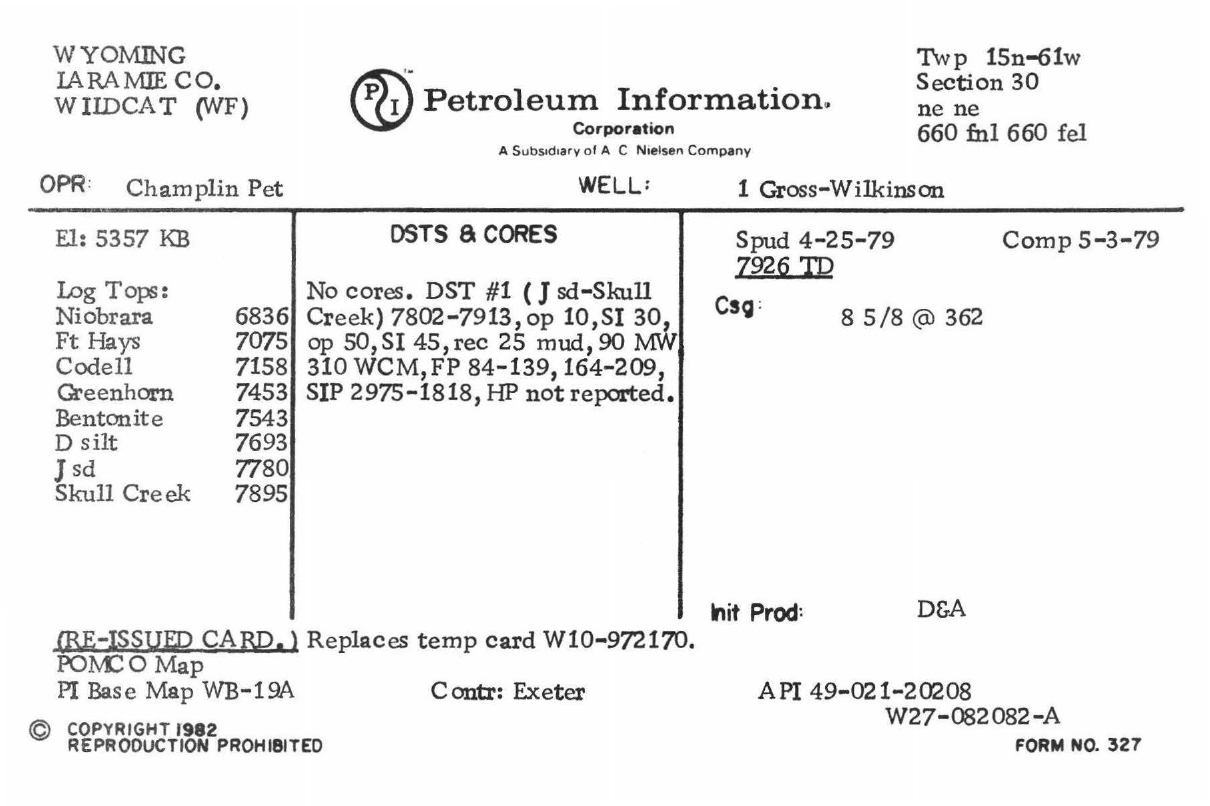

In [29]:
########################################################################3
# boundingBox = True
boundingBox = False
########################################################################
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from pdf2image import convert_from_path
pd.set_option('expand_frame_repr', False)

imgDir = '/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/typeOne/'
boxNo = 'Box6'
imgFile = '156-0045.pdf_page_1.pdf'
poppler = '/pfs/tc1/project/arcc-students/csloan5/environments/GPU_env/bin/'
image = convert_from_path(imgDir+imgFile, poppler_path=poppler)[0]

files = load_csv_filenames('/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/Type_1_CSVs/')




csv_dir = os.path.join('/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/ConvertedCSVFiles/', boxNo)
csv_filename = imgFile + '.csv'

# Read in the TSV file
try:
    csvfile = pd.read_csv(os.path.join(csv_dir, csv_filename), on_bad_lines='skip')
except Exception as e:
    print(e, csv_filename)

csvfile['text'] = csvfile['text'].apply(str)
mask = csvfile['text'] == 'nan'
csvfile = csvfile[~mask]

# Remove any unwanted symbols
csvfile['text'] = csvfile['text'].replace("['~`!=]", "", regex=True)
csvfile['text'] = csvfile['text'].replace(";", ":", regex=True)


# for line in csvfile.itertuples(index=False):
#     print (f"left: {line[6]}, width: {line[8]}, top: {line[7]}, height: {line[9]}, text: {line[11]}\t\t\t{line[6]}, {line[7]}, {line[8]}, {line[9]}")


realigned = realign_text(csvfile, left_dist_def=50, top_dist_def=20)
for line in realigned.itertuples(index=False):
    print (f"left: {line[6]}, width: {line[8]}, top: {line[7]}, height: {line[9]}, text: {line[11]}")



CardDetails = {'DocumentID':os.path.basename(imgFile),\
        'APINum':'','WellName':'','Operator':'','Location':'',\
        'Township':'','Range':'','Section':'','NSFootage':'',\
        'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
        'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
        'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
        'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':''}

Formations = ""
DSTs_and_Cores = ""
# Grab DSTS and Cores Text section before realigning.
for line in csvfile.itertuples(index=False):
    # If it is inside the DST block
    if inside_block(line, 300, 680, 190, 700):
        # Make sure we don't go to far down
        if re.search("([cC]ontr):?", line[11]):
            continue
            
        if DSTs_and_Cores == "":
            DSTs_and_Cores = line[11]
        else:
            DSTs_and_Cores += ' ' + line[11]
            
    # Else if it is inside the TOPs formations block
    elif inside_block(line, 0, 280, 190, 700):
        if Formations == "":
            Formations = line[11]
        else:
            Formations += ' ' + line[11]


parsed = parse_lines(realigned, CardDetails)
parsed = setLocation(parsed)
parsed = setLocationFootage(parsed)

# Add DST and Core information
parsed["DSTS_Cores"] = DSTs_and_Cores.replace('  ', ' ')

# Add TD Formation information
parsed["TDFormation"] = Formations.replace('  ', ' ')

print(f"API: {parsed['APINum']}\nName: {parsed['WellName']}\nOPR: {parsed['Operator']}\nLocation: {parsed['Location']}")
print(f"Township: {parsed['Township']}\nRange: {parsed['Range']}\nSection: {parsed['Section']}")
print(f"NS: {parsed['NSFootage']}\nEW: {parsed['EWFootage']}\nQtrQtr: {parsed['QtrQtr']}")
print(f"LocationFootage: {parsed['LocationFootage']}\nElevation: {parsed['Elevation']}\nSPUD: {parsed['SpudDate']}")
print(f"Comp: {parsed['CompDate']}\nFormations: {parsed['TDFormation']}\nTD: {parsed['TotalDepth']}")
print(f"PBTD: {parsed['PlugBackDepth']}\nCasing: {parsed['Casing']}\nInitProd: {parsed['InitProd']}")
print(f"ProdZone: {parsed['ProdZone']}\nCardNumber: {parsed['CardNumber']}\nStatus: {parsed['WellStatus']}")
print(f"Reissued: {parsed['Reissued']}\nDSTS_Cores: {parsed['DSTS_Cores']}")

if boundingBox:
    plt.imshow(image)

    # Get the current reference
    ax = plt.gca()
    ax.set_axis_off()
    ax.figure.set_size_inches(18.5, 10.5)
    # Create a Rectangle patch

    #         Left  Top  width  height
    coords = [43, 66, 104, 15]
    rect = Rectangle((coords[0], coords[1]), coords[2], coords[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
else:
    image.show()